In [2]:
import os
import random
import numpy as np
import scipy.io
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, roc_curve, auc, classification_report
from sklearn.utils import shuffle
from sklearn.neural_network import MLPClassifier
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import welch

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import sys
# Add the folder to the system path
sys.path.append('/content/drive/MyDrive/EEG_f/')
# Now you can import the file
from read_eeg import get_eeg_info  # or import specific functions, e.g., from read_eeg import read_eeg

In [5]:
def read_egg(path):
    mat = scipy.io.loadmat(path)
    eeg = mat['transferred_EEG']['trial'][0,0][0,0]  # first trial
    return eeg

In [7]:
# --- Parameters ---
healthy_folder = '/content/drive/MyDrive/Data_EEG/Healthy/'
ad_folder = '/content/drive/MyDrive/Data_EEG/AD/'

fs = 500
min_samples = int(1.0 * 60 * fs)
max_samples = int(1.0 * 60 * fs)
num_segments = 50 # extract 50 segments from each sample!

# --- File Loading ---
ad_files = [f for f in os.listdir(ad_folder)]
healthy_files = [f for f in os.listdir(healthy_folder)]

random.seed(1)
random.shuffle(ad_files)
random.shuffle(healthy_files)

AD_data = {}
heal_data = {}

for i in ad_files:
    egg = read_egg(ad_folder + i)
    AD_data[i + '_AD'] = egg

for i in healthy_files:
    egg = read_egg(healthy_folder + i)
    heal_data[i+ '_healthy'] = egg

In [8]:
def split_dict_with_sklearn(data_dict, seed=42):
    keys = list(data_dict.keys())

    # First: split into train (80%) and temp (20%)
    train_keys, temp_keys = train_test_split(keys, test_size=0.4, random_state=seed)

    # Second: split temp into val (10%) and test (10%)
    val_keys, test_keys = train_test_split(temp_keys, test_size=0.5, random_state=seed)

    # Reconstruct dictionaries
    train = {k: data_dict[k] for k in train_keys}
    val   = {k: data_dict[k] for k in val_keys}
    test  = {k: data_dict[k] for k in test_keys}
    return train, val, test

In [9]:
# Apply to each class
ad_train, ad_val, ad_test = split_dict_with_sklearn(AD_data)
hl_train, hl_val, hl_test = split_dict_with_sklearn(heal_data)

# Combine class-wise splits
train_rd = {**ad_train, **hl_train}
val_rd   = {**ad_val, **hl_val}
test_rd  = {**ad_test, **hl_test}

print(f"Train size: {len(train_rd)}, Val: {len(val_rd)}, Test: {len(test_rd)}")

Train size: 19, Val: 6, Test: 7


In [16]:
max_samples

30000

In [12]:
def segment_subjects_non_overlapping(data_dict, segment_len):
    segments = []
    labels = []
    for k, eeg in data_dict.items():
        total_samples = eeg.shape[1]
        print(total_samples)
        num_segments = total_samples // segment_len  # Only full-length segments

        for i in range(num_segments):
            start = i * segment_len
            end = start + segment_len
            segment = eeg[:, start:end]
            segments.append(segment)
            labels.append(1 if '_AD' in k else 0)

    return segments, labels

In [13]:
#bands = {'Delta': (1, 4), 'Theta': (4, 8), 'Alpha': (8, 13), 'Beta': (13, 30), 'Gamma': (30, 70)}
def extract_features(eeg_data, fs):
    features = []
    for seg in eeg_data:
        feature = []
        for ch in seg:
            f, pxx = welch(ch, fs=fs, window='hamming', nperseg=512, noverlap=256, nfft=512) # sliding window that has size of 256 units.
            feature.append(np.array(pxx))
        features.append(np.array(feature))
    print(np.array(features).shape)
    return np.array(features)

In [15]:
# --- Process Data ---
train_data, train_labels = segment_subjects_non_overlapping(train_rd, max_samples)
val_data, val_labels = segment_subjects_non_overlapping(val_rd, max_samples)
test_data, test_labels = segment_subjects_non_overlapping(test_rd, max_samples)

# Balance train set to make both ==
#train_data, train_labels = shuffle(train_data, train_labels, random_state=1)
#ad_idx = [i for i, l in enumerate(train_labels) if l == 1]
#hl_idx = [i for i, l in enumerate(train_labels) if l == 0]
#min_class = min(len(ad_idx), len(hl_idx))
#sel_idx = ad_idx[:min_class] + hl_idx[:min_class]
#train_data = [train_data[i] for i in sel_idx]
#train_labels = [train_labels[i] for i in sel_idx]

# Feature extraction
train_features = extract_features(train_data, fs)
val_features = extract_features(val_data, fs)
test_features = extract_features(test_data, fs)

210000
210000
210000
210000
210000
210000
210000
210000
210000
209500
210000
202500
210000
210000
210000
210000
210000
210000
210000
210000
215000
210000
210000
210000
210000
210000
210000
210000
210000
210000
210000
210000
(131, 19, 257)
(42, 19, 257)
(49, 19, 257)


In [17]:
print(train_features.shape, val_features.shape, test_features.shape)

(131, 19, 257) (42, 19, 257) (49, 19, 257)


In [18]:
print(len(train_labels), len(val_labels), len(test_labels))

131 42 49


In [19]:
print(np.max(train_features))

328.81693


### Data Normalizaion

In [ ]:
def data_normalization(data):
    maxx = np.max(data)
    re = np.zeros((data.shape))
    for i in range(0, data.shape[0]):
        for j in range(0, data.shape[1]):
            re[i, j, :] = data[i, j, :] / maxx
    return re

In [ ]:
train_features = data_normalization(train_features)
val_features = data_normalization(val_features)
test_features = data_normalization(test_features)

### ML pipeline

In [20]:
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, BatchNormalization, Dropout, Flatten, Dense, InputLayer
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc, classification_report
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, AveragePooling1D, BatchNormalization
from tensorflow.keras.layers import Flatten, Dense, Dropout, InputLayer
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2


In [21]:
X_train = np.transpose(train_features, (0, 2, 1))
X_val   = np.transpose(val_features, (0, 2, 1))
X_test  = np.transpose(test_features, (0, 2, 1))

In [22]:
y_train_cat = np.array(train_labels)
y_val_cat   = np.array(val_labels)
y_test_cat  = np.array(test_labels)

In [31]:
X_test.shape

(49, 257, 19)

In [24]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Conv2D, MaxPooling2D, BatchNormalization, Dropout, Flatten, Dense

model = Sequential([
    InputLayer(input_shape=(19, 257, 1)),  # height=19, width=257, 1 channel

    Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.3),

    Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.3),

    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')  # Binary output
])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


In [25]:
from keras.callbacks import ModelCheckpoint

checkpoint = ModelCheckpoint(
    'best_model.h5',              # file to save the best model
    monitor='val_accuracy',       # monitor validation accuracy
    mode='max',                   # we want to maximize accuracy
    save_best_only=True,          # only save the best model
    verbose=1
)

# Compile your model
model.compile(optimizer=Adam(learning_rate=1e-5),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Train the model with checkpoint callback
history = model.fit(X_train, y_train_cat,
                    validation_data=(X_val, y_val_cat),
                    epochs=100,
                    batch_size=32,
                    callbacks=[checkpoint],
                    verbose=1)


Epoch 1/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5647 - loss: 1.7868 
Epoch 1: val_accuracy improved from -inf to 0.38095, saving model to best_model.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 15s 2s/step - accuracy: 0.5584 - loss: 1.7874 - val_accuracy: 0.3810 - val_loss: 0.9238
Epoch 2/100
1/5 ━━━━━━━━━━━━━━━━━━━━ 35s 9s/step - accuracy: 0.4375 - loss: 2.2631
Epoch 2: val_accuracy did not improve from 0.38095
5/5 ━━━━━━━━━━━━━━━━━━━━ 9s 33ms/step - accuracy: 0.4956 - loss: 1.8471 - val_accuracy: 0.2619 - val_loss: 0.9243
Epoch 3/100
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - accuracy: 0.4062 - loss: 1.8959
Epoch 3: val_accuracy did not improve from 0.38095
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.4422 - loss: 1.6563 - val_accuracy: 0.2143 - val_loss: 0.9236
Epoch 4/100
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step - accuracy: 0.6250 - loss: 1.1146
Epoch 4: val_accuracy did not improve from 0.38095
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.5475 - loss: 1.3572 - val_accuracy: 0.1190 - val_loss: 0.9179
Epoch 5/100
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - accuracy: 0.4375 - loss: 1.3269
Epoch 5: val_accuracy did not improve from 0.38095
5/5

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.6917 - loss: 0.7979 - val_accuracy: 0.4048 - val_loss: 0.7067
Epoch 18/100
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 0.5312 - loss: 1.4132
Epoch 18: val_accuracy did not improve from 0.40476
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.6041 - loss: 1.1513 - val_accuracy: 0.4048 - val_loss: 0.7001
Epoch 19/100
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.4688 - loss: 1.1483
Epoch 19: val_accuracy improved from 0.40476 to 0.47619, saving model to best_model.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.5121 - loss: 1.0265 - val_accuracy: 0.4762 - val_loss: 0.6920
Epoch 20/100
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - accuracy: 0.7188 - loss: 0.6488
Epoch 20: val_accuracy improved from 0.47619 to 0.50000, saving model to best_model.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.6620 - loss: 0.6676 - val_accuracy: 0.5000 - val_loss: 0.6840
Epoch 21/100
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 0.6875 - loss: 0.7995
Epoch 21: val_accuracy did not improve from 0.50000
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.6521 - loss: 0.8097 - val_accuracy: 0.5000 - val_loss: 0.6714
Epoch 22/100
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.6562 - loss: 0.6045
Epoch 22: val_accuracy improved from 0.50000 to 0.52381, saving model to best_model.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.5970 - loss: 0.7184 - val_accuracy: 0.5238 - val_loss: 0.6600
Epoch 23/100
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - accuracy: 0.4688 - loss: 1.2334
Epoch 23: val_accuracy did not improve from 0.52381
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.5850 - loss: 0.9012 - val_accuracy: 0.5238 - val_loss: 0.6478
Epoch 24/100
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.5625 - loss: 0.8042
Epoch 24: val_accuracy improved from 0.52381 to 0.54762, saving model to best_model.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.6540 - loss: 0.8248 - val_accuracy: 0.5476 - val_loss: 0.6372
Epoch 25/100
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - accuracy: 0.6250 - loss: 0.6580
Epoch 25: val_accuracy improved from 0.54762 to 0.57143, saving model to best_model.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.6214 - loss: 0.6533 - val_accuracy: 0.5714 - val_loss: 0.6285
Epoch 26/100
1/5 ━━━━━━━━━━━━━━━━━━━━ 1s 267ms/step - accuracy: 0.5312 - loss: 0.8397
Epoch 26: val_accuracy did not improve from 0.57143
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.5438 - loss: 0.9399 - val_accuracy: 0.5476 - val_loss: 0.6184
Epoch 27/100
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.5312 - loss: 0.8391
Epoch 27: val_accuracy did not improve from 0.57143
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.5405 - loss: 0.7939 - val_accuracy: 0.5476 - val_loss: 0.6118
Epoch 28/100
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.6875 - loss: 0.5370
Epoch 28: val_accuracy did not improve from 0.57143
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.6758 - loss: 0.6208 - val_accuracy: 0.5714 - val_loss: 0.6073
Epoch 29/100
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.7500 - loss: 0.5124
Epoch 29: val_accuracy did not improve from 0.5

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.6449 - loss: 0.6815 - val_accuracy: 0.5952 - val_loss: 0.5868
Epoch 32/100
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - accuracy: 0.5938 - loss: 0.8379
Epoch 32: val_accuracy improved from 0.59524 to 0.66667, saving model to best_model.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.6088 - loss: 0.7772 - val_accuracy: 0.6667 - val_loss: 0.5809
Epoch 33/100
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - accuracy: 0.8438 - loss: 0.4694
Epoch 33: val_accuracy did not improve from 0.66667
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.8046 - loss: 0.4854 - val_accuracy: 0.6667 - val_loss: 0.5781
Epoch 34/100
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.5312 - loss: 0.5969
Epoch 34: val_accuracy did not improve from 0.66667
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.5774 - loss: 0.6620 - val_accuracy: 0.6667 - val_loss: 0.5770
Epoch 35/100
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.7188 - loss: 0.6804
Epoch 35: val_accuracy did not improve from 0.66667
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.6710 - loss: 0.6200 - val_accuracy: 0.6667 - val_loss: 0.5740
Epoch 36/100
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.7500 - loss: 0.5530
Epoch 36: val_accuracy improved from 0.66667 to

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.7274 - loss: 0.5811 - val_accuracy: 0.6905 - val_loss: 0.5697
Epoch 37/100
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.7500 - loss: 0.5349
Epoch 37: val_accuracy did not improve from 0.69048
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.6836 - loss: 0.6647 - val_accuracy: 0.6905 - val_loss: 0.5673
Epoch 38/100
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.7500 - loss: 0.5717
Epoch 38: val_accuracy did not improve from 0.69048
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.6749 - loss: 0.7041 - val_accuracy: 0.6905 - val_loss: 0.5618
Epoch 39/100
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.6875 - loss: 0.5379
Epoch 39: val_accuracy did not improve from 0.69048
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.6727 - loss: 0.6696 - val_accuracy: 0.6905 - val_loss: 0.5573
Epoch 40/100
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.6562 - loss: 0.5998
Epoch 40: val_accuracy did not improve from 0.69

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.7205 - loss: 0.6209 - val_accuracy: 0.7143 - val_loss: 0.5357
Epoch 45/100
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8438 - loss: 0.3615
Epoch 45: val_accuracy improved from 0.71429 to 0.73810, saving model to best_model.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.7530 - loss: 0.4791 - val_accuracy: 0.7381 - val_loss: 0.5273
Epoch 46/100
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - accuracy: 0.8125 - loss: 0.4162
Epoch 46: val_accuracy did not improve from 0.73810
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.7518 - loss: 0.5485 - val_accuracy: 0.7381 - val_loss: 0.5216
Epoch 47/100
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.7188 - loss: 0.4616
Epoch 47: val_accuracy did not improve from 0.73810
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.7200 - loss: 0.5084 - val_accuracy: 0.7381 - val_loss: 0.5192
Epoch 48/100
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.6562 - loss: 0.6110
Epoch 48: val_accuracy did not improve from 0.73810
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.6700 - loss: 0.6006 - val_accuracy: 0.7381 - val_loss: 0.5161
Epoch 49/100
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.6562 - loss: 0.5043
Epoch 49: val_accuracy did not improve from 0.7

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.7809 - loss: 0.5253 - val_accuracy: 0.7619 - val_loss: 0.5023
Epoch 53/100
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - accuracy: 0.6250 - loss: 0.6140
Epoch 53: val_accuracy improved from 0.76190 to 0.78571, saving model to best_model.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.6722 - loss: 0.6058 - val_accuracy: 0.7857 - val_loss: 0.4977
Epoch 54/100
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - accuracy: 0.7812 - loss: 0.4283
Epoch 54: val_accuracy did not improve from 0.78571
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.7313 - loss: 0.4885 - val_accuracy: 0.7619 - val_loss: 0.4950
Epoch 55/100
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.4688 - loss: 1.1944
Epoch 55: val_accuracy did not improve from 0.78571
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.6542 - loss: 0.7980 - val_accuracy: 0.7381 - val_loss: 0.4921
Epoch 56/100
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.6250 - loss: 0.6886
Epoch 56: val_accuracy did not improve from 0.78571
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.6968 - loss: 0.5584 - val_accuracy: 0.7381 - val_loss: 0.4897
Epoch 57/100
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.7500 - loss: 0.4783
Epoch 57: val_accuracy did not improve from 0.7

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.7914 - loss: 0.5406 - val_accuracy: 0.8333 - val_loss: 0.4592
Epoch 64/100
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8750 - loss: 0.3954
Epoch 64: val_accuracy did not improve from 0.83333
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.8257 - loss: 0.4659 - val_accuracy: 0.8333 - val_loss: 0.4521
Epoch 65/100
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.6875 - loss: 0.5305
Epoch 65: val_accuracy did not improve from 0.83333
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.7445 - loss: 0.4686 - val_accuracy: 0.8333 - val_loss: 0.4497
Epoch 66/100
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.7812 - loss: 0.6084
Epoch 66: val_accuracy did not improve from 0.83333
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.7812 - loss: 0.5478 - val_accuracy: 0.8333 - val_loss: 0.4485
Epoch 67/100
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8750 - loss: 0.3607
Epoch 67: val_accuracy did not improve from 0.83

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.8175 - loss: 0.4959 - val_accuracy: 0.8571 - val_loss: 0.3905
Epoch 95/100
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.7500 - loss: 0.5199
Epoch 95: val_accuracy improved from 0.85714 to 0.88095, saving model to best_model.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.7837 - loss: 0.5094 - val_accuracy: 0.8810 - val_loss: 0.3854
Epoch 96/100
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 0.7500 - loss: 0.4592
Epoch 96: val_accuracy did not improve from 0.88095
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.7907 - loss: 0.4466 - val_accuracy: 0.8571 - val_loss: 0.3928
Epoch 97/100
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.8438 - loss: 0.3072
Epoch 97: val_accuracy did not improve from 0.88095
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.7637 - loss: 0.4330 - val_accuracy: 0.8095 - val_loss: 0.4064
Epoch 98/100
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - accuracy: 0.7500 - loss: 0.4832
Epoch 98: val_accuracy did not improve from 0.88095
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.7855 - loss: 0.4547 - val_accuracy: 0.7857 - val_loss: 0.4153
Epoch 99/100
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.7500 - loss: 0.4003
Epoch 99: val_accuracy did not improve from 0.

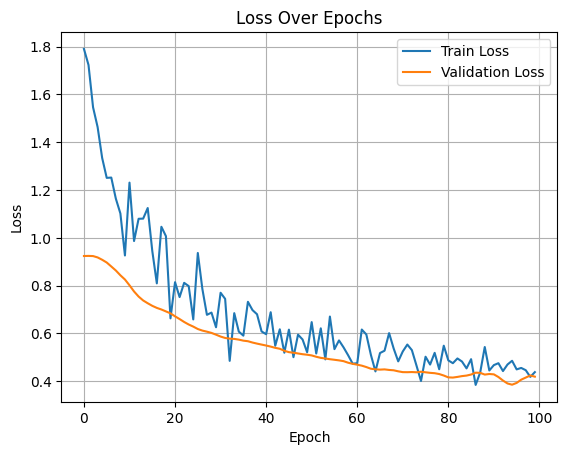

In [26]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

In [27]:
from tensorflow.keras.models import load_model

# Load the best model
#best_model = load_model('best_model.h5')

# Predict
y_pred_probs = model.predict(X_test)

# Convert probabilities to class labels
y_pred_labels = (y_pred_probs > 0.5).astype(int).flatten()

# Compute accuracy
accuracy = np.mean(y_pred_labels == y_test_cat)
print(f"Test Accuracy: {accuracy * 100:.2f}%")


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 803ms/step
Test Accuracy: 63.27%


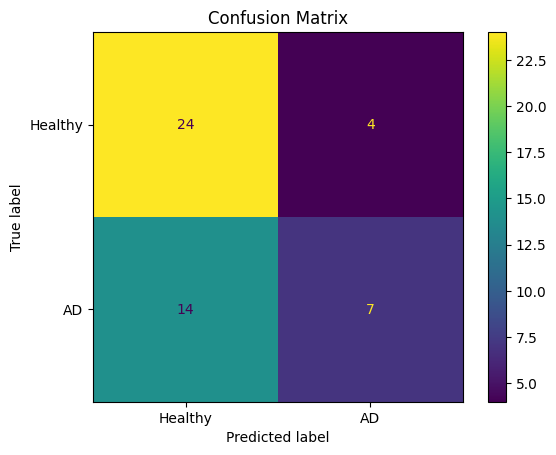

In [29]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Compute confusion matrix
cm = confusion_matrix(y_test_cat, y_pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Healthy', 'AD'])

# Plot
disp.plot(cmap='viridis')
plt.title("Confusion Matrix")
plt.show()
